In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from astropy.io import fits
import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units
from astropy import units as u
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.signal      import argrelextrema

import ehtplot
from matplotlib import pyplot as plt, cm

from common import dalt
from common import hallmark as hm
from common import viz
from common import io_ipole as io
from common import mockservation as ms

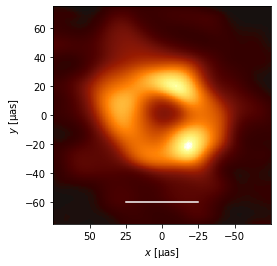

In [2]:
with fits.open('data/img-results/ring1.fits') as hdul:
    img_obs = dalt.Image(hdul[0].data.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0, 79.52842452054078 * 150 / 400, 79.52842452054078 * 150 / 400)
    
fig, ax = plt.subplots(1,1)
viz.show(img_obs, ax=ax, cmap='afmhot_10us')
ax.plot([-25,25], [-60,-60], 'w')

In [3]:
from copy import copy

def compress2(imgs, N=None, sigma=1/(168 * u.uas.to(u.rad))):
    meta = copy(imgs.meta)
    fov  = imgs.fov.to(units.rad).value
    
    spec, U, V = ms.upfft(imgs, *fov, N=N)
    
    u = np.linspace(-U/2,U/2,spec.shape[-2],endpoint=False)
    v = np.linspace( 0,  V/2,spec.shape[-1])
    u, v = np.meshgrid(u, v, indexing='ij')

    G  = np.exp(-(u*u + v*v) / (2 * np.pi * np.pi * sigma * sigma))
    
    I, W, H = ms.downifft(spec * G[np.newaxis,:,:], U, V)
    
    meta.width  = abs(W * meta.dist).to(meta.rg)
    meta.height = abs(H * meta.dist).to(meta.rg)
    return dalt.Image(I, meta=meta)

In [4]:
cmap = cm.get_cmap('afmhot_10us')

def readimg(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
        
    return dalt.Image(data, meta=meta)

def mkplot(axes, fmt_mov, s, eht_f=1e10):
    
    pf_mov = hm.ParaFrame(fmt_mov)
    
    mov_86GHz  = io.load_mov(pf_mov(freq='86GHz' ).path)
    mov_230GHz = io.load_mov(pf_mov(freq='230GHz').path)
    mov_230GHz_eht = compress2(mov_230GHz)

    print(mov_86GHz.shape,  mov_86GHz.fov,  pf_mov(freq='86GHz' ).path)
    print(mov_230GHz.shape, mov_230GHz.fov, pf_mov(freq='230GHz').path)
    print(mov_230GHz_eht.shape)

    viz.show(mov_86GHz,  s=s, ax=axes[0], cmap=cmap, vmin=0, vmax=np.max(mov_86GHz.value))
    axes[0].set_xlim( 70,-70)
    axes[0].set_ylim(-70, 70)
    axes[0].set_xlabel(None)
    axes[0].set_ylabel(None)
    axes[0].tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True,
        color='w',
    )
    for spine in axes[0].spines.values():
        spine.set_edgecolor('w')
    
    viz.show(mov_230GHz, s=s, ax=axes[1], cmap=cmap, vmin=0, vmax=np.max(mov_230GHz_eht.value))
    axes[1].set_xlim( 70,-70)
    axes[1].set_ylim(-70, 70)
    axes[1].set_xlabel(None)
    axes[1].set_ylabel(None)
    axes[1].tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True,
        color='w',
    )
    for spine in axes[1].spines.values():
        spine.set_edgecolor('w')

    viz.show(mov_230GHz_eht, s=s, ax=axes[2], cmap=cmap, vmin=0, vmax=np.max(mov_230GHz_eht.value))
    axes[2].set_xlim( 70,-70)
    axes[2].set_ylim(-70, 70)
    axes[2].set_xlabel(None)
    axes[2].set_ylabel(None)
    axes[2].tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True,
        color='w',
    )
    for spine in axes[2].spines.values():
        spine.set_edgecolor('w')

(400, 400) -> [400 400]
(400, 400) -> [400 400]
(1, 400, 400) [-199.99981213  199.99981213] uas 1    model/Illinois_thermal/86GHz/Ma+0.5_w5/img_s05...
Name: path, dtype: object
(1, 400, 400) [-199.99981213  199.99981213] uas 0    model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s0...
Name: path, dtype: object
(1, 400, 400)


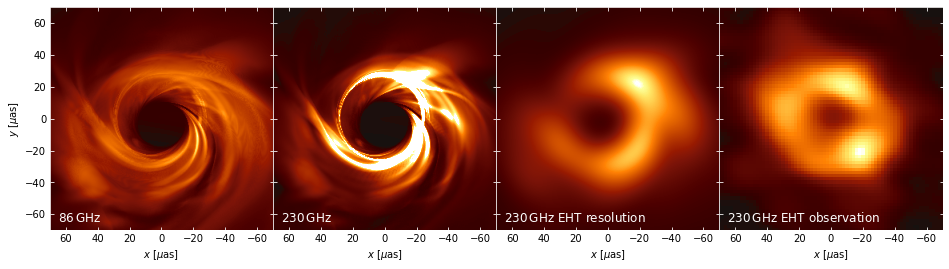

In [5]:
fig, axes = plt.subplots(1,4, figsize=(16,5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

mkplot(axes, 'model/Illinois_thermal/{freq}/Ma+0.5_w5/img_s05511_Rh160_i30.h5', 0) #98

viz.show(img_obs, ax=axes[3], cmap='afmhot_10us')
axes[3].set_aspect('equal')
axes[3].set_xlim( 70,-70)
axes[3].set_ylim(-70, 70)
axes[3].set_xlabel(None)
axes[3].set_ylabel(None)
axes[3].tick_params(
    axis='both',
    direction='in',
    top=True,
    right=True,
    color='w',
)
for spine in axes[3].spines.values():
    spine.set_edgecolor('w')

axes[0].set_ylabel('$y$ [$\mu$as]')
axes[0].set_xlabel('$x$ [$\mu$as]')
axes[1].set_xlabel('$x$ [$\mu$as]')
axes[2].set_xlabel('$x$ [$\mu$as]')
axes[3].set_xlabel('$x$ [$\mu$as]')
axes[0].text(65,-65, '$86\,\mathrm{GHz}$',                  color='w', fontsize=12)
axes[1].text(65,-65, '$230\,\mathrm{GHz}$',                 color='w', fontsize=12)
axes[2].text(65,-65, '$230\,\mathrm{GHz}$ EHT resolution',  color='w', fontsize=12)
axes[3].text(65,-65, '$230\,\mathrm{GHz}$ EHT observation', color='w', fontsize=12)

fig.savefig('output/bestbet_imgs.pdf', bbox_inches='tight')